In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import	KMeans

### Read data

In [2]:
credit = pd.read_excel('../LIVE PROJECT/CreditAnalysis_data.xlsx')
credit.head()

,Unnamed: 0,master_order_id,master_order_status,created,order_id,order_status,ordereditem_quantity,prod_names,ordereditem_unit_price_net,ordereditem_product_id,value,group,dist_names,retailer_names,bill_amount
0,1,25651,delivered,12/18/2017 10:41,25651,delivered,5,ProdName1,43.00,1744.0,215.00,Hyderabad,DistName1,RetailerID2,809.0
1,2,25651,delivered,12/18/2017 10:41,25651,delivered,5,ProdName2,35.54,965.0,177.70,Hyderabad,DistName1,RetailerID2,809.0
2,3,25651,delivered,12/18/2017 10:41,25651,delivered,2,ProdName3,52.80,705.0,105.60,Hyderabad,DistName3,RetailerID29,809.0
3,4,25651,delivered,12/18/2017 10:41,25651,delivered,2,ProdName4,118.28,264.0,236.56,Hyderabad,DistName1,RetailerID87,809.0
4,5,25651,delivered,12/18/2017 10:41,25651,delivered,3,ProdName5,32.22,1025.0,96.66,Hyderabad,DistName4,RetailerID118,809.0


We remove all the unnecessary information decided earlier and save into `clean_credit`.

In [3]:
clean_credit = credit[(credit['value']!= 0)]

In [4]:
clean_credit = clean_credit[(clean_credit['master_order_status'] != 'cancelled') & (clean_credit['master_order_status'] != 'rejected')]

All missing values have been handled. Unnecessary rows are removed (rejected, cancelled and new orders).

Since `master_order_id` not unique to each retailers, so we have to create a new column with order id unique to each retailers:

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
clean_credit['dummy_name'] = le.fit_transform(clean_credit.retailer_names.values)
clean_credit['dummy_group'] = le.fit_transform(clean_credit.group.values)
clean_credit['invoice_id'] = clean_credit.dummy_group.astype(str) + clean_credit.dummy_name.astype(str) + clean_credit.master_order_id.astype(str)


In [6]:
clean_credit.head(10)

,Unnamed: 0,master_order_id,master_order_status,created,order_id,order_status,ordereditem_quantity,prod_names,ordereditem_unit_price_net,ordereditem_product_id,value,group,dist_names,retailer_names,bill_amount,dummy_name,dummy_group,invoice_id
0,1,25651,delivered,12/18/2017 10:41,25651,delivered,5,ProdName1,43.00,1744.0,215.00,Hyderabad,DistName1,RetailerID2,809.0,99,2,29925651
1,2,25651,delivered,12/18/2017 10:41,25651,delivered,5,ProdName2,35.54,965.0,177.70,Hyderabad,DistName1,RetailerID2,809.0,99,2,29925651
2,3,25651,delivered,12/18/2017 10:41,25651,delivered,2,ProdName3,52.80,705.0,105.60,Hyderabad,DistName3,RetailerID29,809.0,141,2,214125651
3,4,25651,delivered,12/18/2017 10:41,25651,delivered,2,ProdName4,118.28,264.0,236.56,Hyderabad,DistName1,RetailerID87,809.0,202,2,220225651
4,5,25651,delivered,12/18/2017 10:41,25651,delivered,3,ProdName5,32.22,1025.0,96.66,Hyderabad,DistName4,RetailerID118,809.0,16,2,21625651
5,6,25651,delivered,12/18/2017 10:41,25651,delivered,2,ProdName6,12.60,NaN,25.20,Hyderabad,DistName7,RetailerID112,809.0,11,2,21125651
6,7,25652,delivered,12/19/2017 6:48,25652,delivered,2,ProdName7,107.86,5192.0,215.72,Hyderabad,DistName1,RetailerID116,566.0,14,2,21425652
7,8,25652,delivered,12/19/2017 6:48,25652,delivered,3,ProdName8,31.25,5452.0,93.75,Hyderabad,DistName6,RetailerID55,566.0,170,2,217025652
8,9,25652,delivered,12/19/2017 6:48,25652,delivered,2,ProdName9,61.88,4383.0,123.76,Hyderabad,DistName1,RetailerID13,566.0,27,2,22725652
9,10,25654,delivered,12/19/2017 7:57,25654,delivered,5,ProdName10,19.44,922.0,97.20,Hyderabad,DistName1,RetailerID56,468.0,171,2,217125654


## Calculate RFM Values

In [8]:
import datetime as dt
from datetime import timedelta

In [7]:
# Let's observe the last transaction date.
# So we can determine the performans/measurement date for calculating how recent retailer's latest purchase was.
clean_credit['created'] = pd.to_datetime(clean_credit['created'])
clean_credit['created'].max()
clean_credit['created'].min()

Timestamp('2017-12-18 10:41:00')

In [ ]:
clean_credit['created'].describe()

In [ ]:
clean_credit['created'].max() - clean_credit['created'].min()

In [ ]:
clean_credit

In [9]:
clean_credit['created_year'] = clean_credit['created'].dt.year
clean_credit['created_month'] = clean_credit['created'].dt.month
clean_credit['created_hour'] = clean_credit['created'].dt.hour
clean_credit['created_year_month'] = (
    clean_credit['created'].dt.year.astype('str') + '_' +
    clean_credit['created'].dt.month.astype('str').str.zfill(2)
)
clean_credit['created_dayofweek'] = clean_credit['created'].dt.dayofweek

In [ ]:
clean_credit.head()

- Calculating Recency: 
For each customer ID, we need to calculate the days since the last transaction.
To calculate Days Since Last Transaction, a hypothetical date (Maximum Date + 2) is created to make it seem like we are working on the data 2 days after it was extracted.
Finally, the difference between the Maximum InvoiceDate for each customer and the hypothetical Date created gives us the Date Since the last transaction.

In [10]:
# Assign "performans_date" as 2 days after the last transaction date of purchase:
performans_date = clean_credit["created"].max() + timedelta(days=2)
performans_date

Timestamp('2018-12-05 18:26:00')

Let's create a new dataframe called `customer_data` for calculating Recency, Frequency and Monetary values.
1. Recency : the number of days between performans_date and the last purchase date of each retailer.
2. Frequency: the number of transactions of each retailer.
3. Monetary : the sum of TotalPrice of each retailer.

In [11]:
# Aggregate at customer level
customer_data = pd.DataFrame(clean_credit.pivot_table(index="retailer_names", 
                values=["created", "bill_amount",'invoice_id'], 
            aggfunc={"created": [min, max], "bill_amount": sum, 'invoice_id':pd.Series.nunique}))



customer_data.head()

bill_amount             created                     invoice_id
                       sum                 max                 min    nunique
retailer_names                                                               
RetailerID1      421557.97 2018-12-03 16:52:00 2018-01-02 06:56:00        189
RetailerID10      68787.08 2018-12-03 06:54:00 2018-01-23 06:30:00         36
RetailerID100    107256.37 2018-12-02 08:01:00 2018-01-03 05:53:00         57
RetailerID101    574727.13 2018-12-03 15:33:00 2017-12-19 07:31:00        265
RetailerID102     35524.84 2018-11-03 13:57:00 2018-01-30 06:51:00         14

In [12]:
# Rename columns
customer_data.columns = ["MonetaryValue", "LastInvoiceDate", "FirstInvoiceDate", "Frequency"]
customer_data.head()

,MonetaryValue,LastInvoiceDate,FirstInvoiceDate,Frequency
retailer_names,,,,
RetailerID1,421557.97,2018-12-03 16:52:00,2018-01-02 06:56:00,189
RetailerID10,68787.08,2018-12-03 06:54:00,2018-01-23 06:30:00,36
RetailerID100,107256.37,2018-12-02 08:01:00,2018-01-03 05:53:00,57
RetailerID101,574727.13,2018-12-03 15:33:00,2017-12-19 07:31:00,265
RetailerID102,35524.84,2018-11-03 13:57:00,2018-01-30 06:51:00,14


<AxesSubplot:>

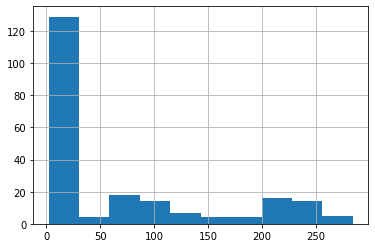

In [13]:
# Calculate recency: the interval (days) between the last transation day and today
customer_data["Recency"] = (performans_date - customer_data["LastInvoiceDate"]) / np.timedelta64(1, 'D')

customer_data["Recency"].hist()

In [ ]:
#customer_data["Frequency"].hist()

sns.distplot( customer_data["MonetaryValue"] , color="darkblue")
print("Skewness: %f" % customer_data["MonetaryValue"].skew())
print("Kurtosis: %f" % customer_data["MonetaryValue"].kurt())


<AxesSubplot:>

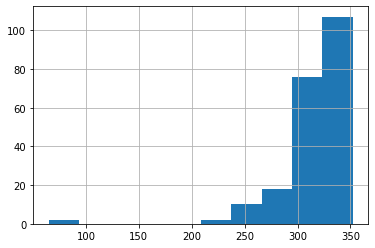

In [14]:
# Calculate retailer lifetime: the interval (days) between the first transaction day and today
customer_data["Lifetime"] = (performans_date - customer_data["FirstInvoiceDate"]) / np.timedelta64(1, 'D')

customer_data["Lifetime"].hist()

In [ ]:
plt.boxplot(customer_data.Lifetime) 

In [ ]:
customer_data["Frequency"].hist()

In [ ]:
customer_data["MonetaryValue"].describe() 

In [ ]:
sns.displot(customer_data, x="Lifetime", kind="kde", bw_adjust=2)

In [ ]:
customer_data["Recency"].describe()

In [ ]:
customer_data["MonetaryValue"].describe()

In [ ]:
customer_data["MonetaryValue"].hist()
# There are some outliers in terms of monetary value.

In [17]:
Univ1 = customer_data.reset_index() # convert into dataframe

### K-Means Clustering of RFM Values

In [19]:
Univ = Univ1[['retailer_names','MonetaryValue', 'Frequency', 'Recency','Lifetime']]

In [20]:
Univ_num = Univ1[['MonetaryValue', 'Frequency', 'Recency','Lifetime']]

In [22]:
## Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Acer\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Recency's: Skew: 1.1915843590096797, : SkewtestResult(statistic=6.000440984814466, pvalue=1.967823629232138e-09)
Frequency's: Skew: 3.9209491681371786, : SkewtestResult(statistic=11.799722791237931, pvalue=3.915993394533396e-32)


C:\Users\Acer\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MonetaryValue's: Skew: 5.932043326086408, : SkewtestResult(statistic=13.962009490410134, pvalue=2.6583151996944115e-44)


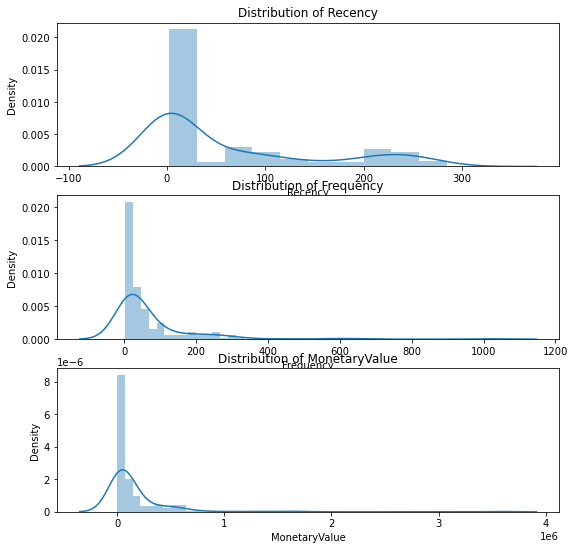

In [23]:
plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
check_skew(Univ_num,'Recency')
plt.subplot(3, 1, 2)
check_skew(Univ_num,'Frequency')
plt.subplot(3, 1, 3)
check_skew(Univ_num,'MonetaryValue')


Normalize the values

In [21]:
#Removing Skewness
df_rfm_log = np.log(Univ_num)

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Acer\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Recency's: Skew: 0.5032504491659885, : SkewtestResult(statistic=2.9547366887798567, pvalue=0.0031293600912372637)
Frequency's: Skew: -0.048870662730500815, : SkewtestResult(statistic=-0.30182823252158597, pvalue=0.7627830075426971)


C:\Users\Acer\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MonetaryValue's: Skew: -0.37057837205613325, : SkewtestResult(statistic=-2.224253018442685, pvalue=0.026131425731922207)


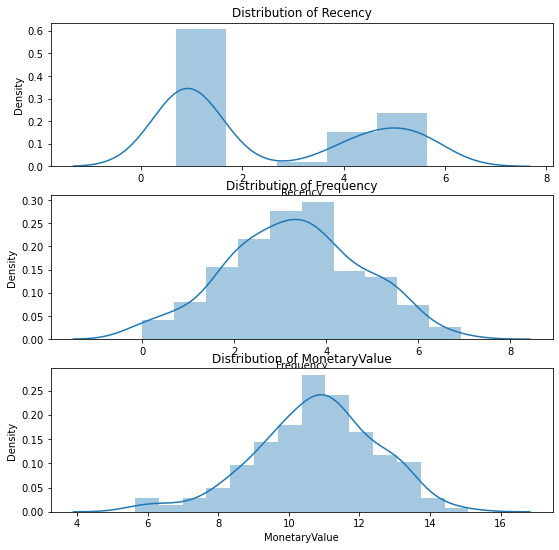

In [26]:
plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')
plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'MonetaryValue')


In [22]:
# scale data
scaler = StandardScaler()
scaler.fit(df_rfm_log)
df_norm= scaler.transform(df_rfm_log)
df_norm = pd.DataFrame(df_norm, columns = df_rfm_log.columns)
df_norm.head()

,MonetaryValue,Frequency,Recency,Lifetime
0,1.277300,1.330597,-0.902163,0.411699
1,0.211215,0.194697,-0.809165,0.016590
2,0.472427,0.509480,-0.644074,0.394233
3,1.459557,1.562118,-0.888856,0.661468
4,-0.177353,-0.452268,0.491799,-0.121367


C:\Users\Acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows wi

Text(0, 0.5, 'total_within_SS')

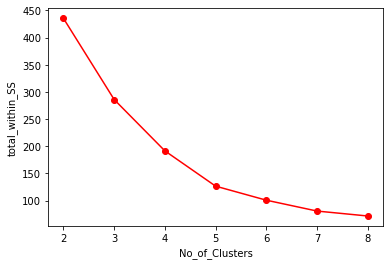

In [28]:
# elbow curve 
TWSS = []
k = list(range(2,9))

for i in k:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(df_norm)
    TWSS.append(kmeans.inertia_)

TWSS
# Scree plot (elbow curve)
plt.plot(k, TWSS, 'ro-');plt.xlabel("No_of_Clusters");plt.ylabel("total_within_SS")

In [23]:
# Selecting 5 clusters from the above scree plot which is the optimum number of clusters 
model = KMeans(n_clusters = 5)
model.fit(df_norm)

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5)

In [24]:
model.labels_ # getting the labels of clusters assigned to each row 
mb = pd.Series(model.labels_)  # converting numpy array into pandas series object 
Univ['clust'] = mb # creating a  new column  

C:\Users\Acer\AppData\Local\Temp\ipykernel_6552\2535878820.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Univ['clust'] = mb # creating a  new column and assigning it to new column


In [25]:
Univ.rename(columns={'clust': 'CreditScore'}, inplace=True)
Univ.head()

C:\Users\Acer\AppData\Local\Temp\ipykernel_6552\1652505865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Univ.rename(columns={'clust': 'CreditScore'}, inplace=True)


,retailer_names,MonetaryValue,Frequency,Recency,Lifetime,CreditScore
0,RetailerID1,421557.97,189,2.065278,337.479167,0
1,RetailerID10,68787.08,36,2.480556,316.497222,3
2,RetailerID100,107256.37,57,3.434028,336.522917,3
3,RetailerID101,574727.13,265,2.120139,351.454861,0
4,RetailerID102,35524.84,14,32.186806,309.482639,4


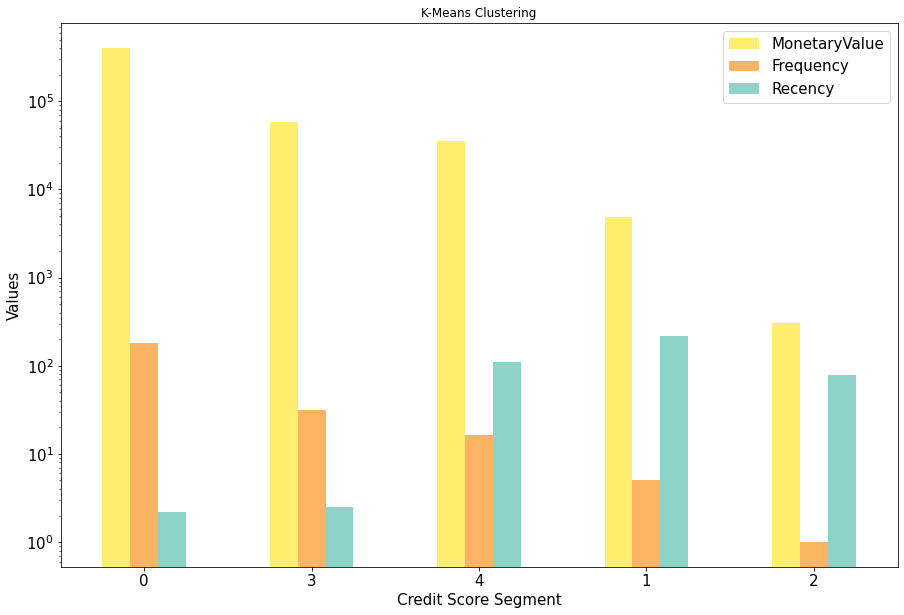

In [26]:
grouped_Univ = Univ[['retailer_names', 'MonetaryValue', 'Frequency', 'Recency',
       'CreditScore']].groupby('CreditScore').median()
grouped_Univ.sort_values(['MonetaryValue'], ascending=False,inplace=True)
myfig = grouped_Univ.plot(kind='bar',logy=True, colormap='Set3_r', fontsize=15, figsize=(15,10)) 
#plt.legend(bbox_to_anchor=(x,y))  
#plt.yticks(rotation=0)
plt.title("K-Means Clustering")
#plt.text(v, i, " "+str(v), color='blue', va='center', fontweight='bold')
plt.xticks(rotation=0)
plt.xlabel('Credit Score Segment', fontsize=15)
plt.ylabel('Values', fontsize=15)
plt.legend(fontsize=15) # using a size in points
#plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12) 
plt.show()

In [28]:
# Rename clusters with credit score segment
Univ.loc[Univ['CreditScore'] == 0,'CreditScore'] ='01. Excellent'
Univ.loc[Univ['CreditScore'] == 3,'CreditScore'] ='02. Good'
Univ.loc[Univ['CreditScore'] == 4,'CreditScore'] ='03. Moderate'
Univ.loc[Univ['CreditScore'] == 1,'CreditScore'] ='04. Fair'
Univ.loc[Univ['CreditScore'] == 2,'CreditScore'] ='05. Poor'

C:\Users\Acer\AppData\Local\Temp\ipykernel_6552\3211324422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Univ.loc[Univ['CreditScore'] == 0,'CreditScore'] ='01. Excellent'


In [29]:
Univ.pivot_table(index=["CreditScore"], 
                          values=["Recency", "Frequency", "MonetaryValue", "Lifetime"], 
                          aggfunc={"Recency": [np.min, np.median, np.max], 
                                   "Frequency": [np.min, np.median, np.max], 
                                   "MonetaryValue": [np.min, np.median, np.max], 
                                   "Lifetime": [np.min, np.median, np.max, "count"]})

Frequency                Lifetime                                \
                   amax amin median        amax        amin count      median   
CreditScore                                                                     
01. Excellent      1022   74  180.0  352.322917  317.390278    55  348.587500   
02. Good             59    4   31.5  352.322917  263.547917    74  316.491319   
03. Moderate         77    7   16.5  352.322917  285.529861    48  314.375000   
04. Fair              9    1    5.0  336.264583  216.000000    36  284.468403   
05. Poor              1    1    1.0   93.199306   64.538194     2   78.868750   

              MonetaryValue                            Recency             \
                       amax       amin      median        amax       amin   
CreditScore                                                                 
01. Excellent    3562912.89  117631.62  402308.790   32.436111   2.000000   
02. Good          178500.88    5614.12   58261.915    3.661806   2.120139   
03. Moderate      187520.97    9862.04   35502.560  254.425694  32.172222   
04. Fair           21175.44     425.42    4924.910  284.584722   2.552083   
05. Poor             336.00     281.00     308.500   93.199306  64.538194   

                           
                   median  
CreditScore                
01. Excellent    2.190972  
02. Good         2.526389  
03. Moderate   109.275000  
04. Fair       215.542014  
05. Poor        78.868750

In [30]:
Univ.head()

,retailer_names,MonetaryValue,Frequency,Recency,Lifetime,CreditScore
0,RetailerID1,421557.97,189,2.065278,337.479167,01. Excellent
1,RetailerID10,68787.08,36,2.480556,316.497222,02. Good
2,RetailerID100,107256.37,57,3.434028,336.522917,02. Good
3,RetailerID101,574727.13,265,2.120139,351.454861,01. Excellent
4,RetailerID102,35524.84,14,32.186806,309.482639,03. Moderate


### Data merged with retailer credit score clusters

In [31]:
final_cluster = clean_credit.merge(right=Univ, how="inner", left_on="retailer_names", right_on="retailer_names")
final_cluster.head(3)

,Unnamed: 0,master_order_id,master_order_status,created,order_id,order_status,ordereditem_quantity,prod_names,ordereditem_unit_price_net,ordereditem_product_id,...,created_year,created_month,created_hour,created_year_month,created_dayofweek,MonetaryValue,Frequency,Recency,Lifetime,CreditScore
0,1,25651,delivered,2017-12-18 10:41:00,25651,delivered,5,ProdName1,43.00,1744.0,...,2017,12,10,2017_12,0,127477.66,77,2.552083,352.322917,01. Excellent
1,2,25651,delivered,2017-12-18 10:41:00,25651,delivered,5,ProdName2,35.54,965.0,...,2017,12,10,2017_12,0,127477.66,77,2.552083,352.322917,01. Excellent
2,143,25684,processed,2018-01-23 06:30:00,25688,processed,2,ProdName118,48.29,1728.0,...,2018,1,6,2018_01,1,127477.66,77,2.552083,352.322917,01. Excellent


In [32]:
# create excel writer object
writer = pd.ExcelWriter('final_cluster.xlsx')
# write dataframe to excel
final_cluster.to_excel(writer)
# save the excel
writer.save()